# Часть 1

In [ ]:
#pip install torch

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch import nn
from tqdm import tqdm

Изменим сеть LeNet, для повышения качества на валидации. Функции активации tanh() уже не используют, так как они приводят к затуханию градиента. Свертку 5 на 5 тоже не используют, используют две свертки 3 на 3 (весов меньше, следовательно, меньше вероятность переобучения). AvdPool тоже не используют. Нужно заменить на MaxPool.

Мы использовали датасет MNIST, но на нем сети всегда хорошо обучаются. Возьмем датасет посложнее -  CIFAR-10, 10 классов, а есть CIFAR-100, 100 классов.

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [6]:
#скачивание датасета для классификации изображений
import torchvision.datasets

CIFAR_train = torchvision.datasets.CIFAR10('./', download = True, train = True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download = True, train = False)

100%|██████████| 170498071/170498071 [00:06<00:00, 24435147.64it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
X_train.min(),X_train.max()

(tensor(0.), tensor(255.))

Каждый цвет кодируется от 0 до 255 в виде float. Чтобы отобразить, нужны либо int 0-255, либо float 0-1. У нас тензоры float.

In [9]:
X_train/= 255
X_test/= 255

In [10]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

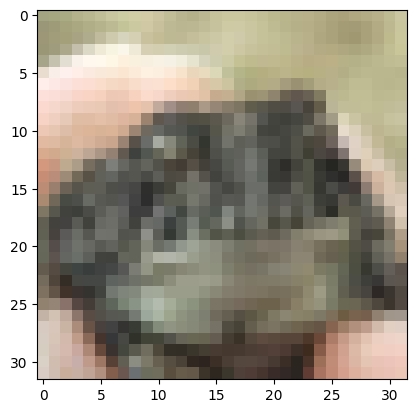

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X_train[25])

In [12]:
X_train.shape

torch.Size([50000, 32, 32, 3])

Не та размерность.

Надо (кол-во изображений, кол-во каналов, высота, ширина). Каналы должны быть на 2 месте. Здесь на 4.

In [13]:
# с помощью метода permute изменить размерность тензора
X_train = torch.permute(X_train, (0, 3, 1, 2))
X_test =  torch.permute(X_test, (0, 3, 1, 2))

In [14]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Функция для обучения

In [16]:
def fit_model(batch_size, 
              epochs,
              X_test,
              X_train,
              y_test,
              y_train,
              model,
              optimizer):
    

    loss_function = nn.CrossEntropyLoss()
    
    '''перекладываем входные данные теста на видеокарту'''
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    train_losses = []
    test_losses = []

    '''данные тренировочной выборки будем перекладывать на cuda по батчам'''
    for epoch in tqdm(range(epochs)):
      order = np.random.permutation(len(X_train))
      for start_index in range (0,len(X_train), batch_size):

        model.train() # перевод в режим train

        optimizer.zero_grad() # обнуляем градиенты

        batch_index = order[start_index:start_index+batch_size] # выделение батча из датасета
        X_batch = X_train[batch_index] #
        y_batch = y_train[batch_index] #

        preds = model.forward(X_batch) # предсказание на батче
        loss_val = loss_function(preds, y_batch) # лосс на батче
        train_losses.append(loss_val) # сохраняем лосс на трейне

        loss_val.backward() # расчет градиентов
        optimizer.step() # шаг градиента + оптимизатора
        
        with torch.no_grad():
            loss_test = loss_function(model.forward(X_test), y_test) # лосс на тесте
            test_losses.append(loss_test) # сохраняем лосс на тесте

    return [train_losses, test_losses]

## Классический LeNet5

In [17]:
class LeNet5(torch.nn.Module):
  def __init__(self):
    super (LeNet5, self).__init__()
    #посмотреть архитектуру LeNet в презентации

    #Свертка torch.nn.Conv2d(in_channels = вход.каналы, out_channels=выход.каналы, kernel_size = ядро, padding = сколько надо паддинга)
    #Пулинг torch.nn.AvgPool2d (kernel_size= , stride= )
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
    self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Tanh())
    self.linear = nn.Sequential(
            nn.Linear(576, 32),
            nn.Tanh(),
            nn.Linear(32, 10))
    self.sm = nn.Softmax()
    
    

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    #растягиваем тензор
    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
    #x = torch.flatten(x)
    ###################
    x = self.linear(x)
    return x

  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x


In [44]:
basic_lenet = LeNet5().to(device)
optimizer1 = torch.optim.Adam(params = basic_lenet.parameters())

In [45]:
base_result = fit_model(batch_size = 1000, 
                        epochs = 20,
                        X_test = X_test,
                        X_train = X_train,
                        y_test = y_test,
                        y_train = y_train,
                        model = basic_lenet,
                        optimizer = optimizer1)
    

100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


In [46]:
train_res_1 = [i.to('cpu').tolist() for i in base_result[0]]
test_res_1 = [i.to('cpu').tolist() for i in base_result[1]]

## LeNet с ReLU

In [47]:
class LeNet_with_ReLU(torch.nn.Module):
  def __init__(self):
    super (LeNet_with_ReLU, self).__init__()

    #Свертка torch.nn.Conv2d(in_channels = вход.каналы, out_channels=выход.каналы, kernel_size = ядро, padding = сколько надо паддинга)
    #Пулинг torch.nn.AvgPool2d (kernel_size= , stride= )
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
    self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.ReLU())
    self.linear = nn.Sequential(
            nn.Linear(576, 32),
            nn.ReLU(),
            nn.Linear(32, 10))
    self.sm = nn.Softmax()
    
    

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    #растягиваем тензор
    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
    #x = torch.flatten(x)
    ###################
    x = self.linear(x)
    return x

  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x

In [48]:
relu_lenet = LeNet_with_ReLU().to(device)
optimizer2 = torch.optim.Adam(params = relu_lenet.parameters())

In [49]:
relu_result = fit_model(batch_size = 1000, 
                        epochs = 20,
                        X_test = X_test,
                        X_train = X_train,
                        y_test = y_test,
                        y_train = y_train,
                        model = relu_lenet,
                        optimizer = optimizer2)

100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


In [50]:
train_res_2 = [i.to('cpu').tolist() for i in relu_result[0]]
test_res_2 = [i.to('cpu').tolist() for i in relu_result[1]]

## LeNet с ReLU и MaxPool

In [51]:
class LeNet_with_ReLU_MaxPool(torch.nn.Module):
  def __init__(self):
    super (LeNet_with_ReLU_MaxPool, self).__init__()

    #Свертка torch.nn.Conv2d(in_channels = вход.каналы, out_channels=выход.каналы, kernel_size = ядро, padding = сколько надо паддинга)
    #Пулинг torch.nn.AvgPool2d (kernel_size= , stride= )
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU())
    self.linear = nn.Sequential(
            nn.Linear(576, 32),
            nn.ReLU(),
            nn.Linear(32, 10))
    self.sm = nn.Softmax()
    
    

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    #растягиваем тензор
    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
    #x = torch.flatten(x)
    ###################
    x = self.linear(x)
    return x

  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x

In [52]:
relu_maxpool_lenet = LeNet_with_ReLU_MaxPool().to(device)
optimizer3 = torch.optim.Adam(params = relu_maxpool_lenet.parameters())

In [53]:
relu_maxpool_result = fit_model(batch_size = 1000, 
                                epochs = 20,
                                X_test = X_test,
                                X_train = X_train,
                                y_test = y_test,
                                y_train = y_train,
                                model = relu_maxpool_lenet,
                                optimizer = optimizer3)

100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


In [54]:
train_res_3 = [i.to('cpu').tolist() for i in relu_maxpool_result[0]]
test_res_3 = [i.to('cpu').tolist() for i in relu_maxpool_result[1]]

## LeNet с ReLU, MaxPool, double Conv 3x3

In [55]:
class LeNet_RMD(torch.nn.Module):
  def __init__(self):
    super (LeNet_RMD, self).__init__()

    #Свертка torch.nn.Conv2d(in_channels = вход.каналы, out_channels=выход.каналы, kernel_size = ядро, padding = сколько надо паддинга)
    #Пулинг torch.nn.AvgPool2d (kernel_size= , stride= )
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU())
    self.linear = nn.Sequential(
            nn.Linear(576, 32),
            nn.ReLU(),
            nn.Linear(32, 10))
    self.sm = nn.Softmax()
    
    

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    #растягиваем тензор
    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
    #x = torch.flatten(x)
    ###################
    x = self.linear(x)
    return x

  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x

In [56]:
lenet_rmd = LeNet_RMD().to(device)
optimizer4 = torch.optim.Adam(params = lenet_rmd.parameters())

In [57]:
rmd_result = fit_model(batch_size = 1000, 
                       epochs = 20,
                       X_test = X_test,
                       X_train = X_train,
                       y_test = y_test,
                       y_train = y_train,
                       model = lenet_rmd,
                       optimizer = optimizer4)

100%|██████████| 20/20 [01:25<00:00,  4.25s/it]


In [58]:
train_res_4 = [i.to('cpu').tolist() for i in rmd_result[0]]
test_res_4 = [i.to('cpu').tolist() for i in rmd_result[1]]

## LeNet с ReLU, MaxPool, double Conv 3x3 и Batch Norm

In [59]:
class LeNet_RMDB(torch.nn.Module):
  def __init__(self):
    super (LeNet_RMDB, self).__init__()

    #Свертка torch.nn.Conv2d(in_channels = вход.каналы, out_channels=выход.каналы, kernel_size = ядро, padding = сколько надо паддинга)
    #Пулинг torch.nn.AvgPool2d (kernel_size= , stride= )
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3, stride = 1, padding = 2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU())
    self.linear = nn.Sequential(
            nn.Linear(576, 32),
            nn.ReLU(),
            nn.Linear(32, 10))
    self.sm = nn.Softmax()
    
    

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    #растягиваем тензор
    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))
    #x = torch.flatten(x)
    ###################
    x = self.linear(x)
    return x

  def predict(self,x):
    x=self.forward(x)
    x=self.sm(x)
    return x

In [60]:
lenet_rmdb = LeNet_RMDB().to(device)
optimizer5 = torch.optim.Adam(params = lenet_rmdb.parameters())

In [61]:
rmdb_result = fit_model(batch_size = 1000, 
                       epochs = 20,
                       X_test = X_test,
                       X_train = X_train,
                       y_test = y_test,
                       y_train = y_train,
                       model = lenet_rmdb,
                       optimizer = optimizer5)

100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


In [62]:
train_res_5 = [i.to('cpu').tolist() for i in rmdb_result[0]]
test_res_5 = [i.to('cpu').tolist() for i in rmdb_result[1]]

## График лоссов на тесте

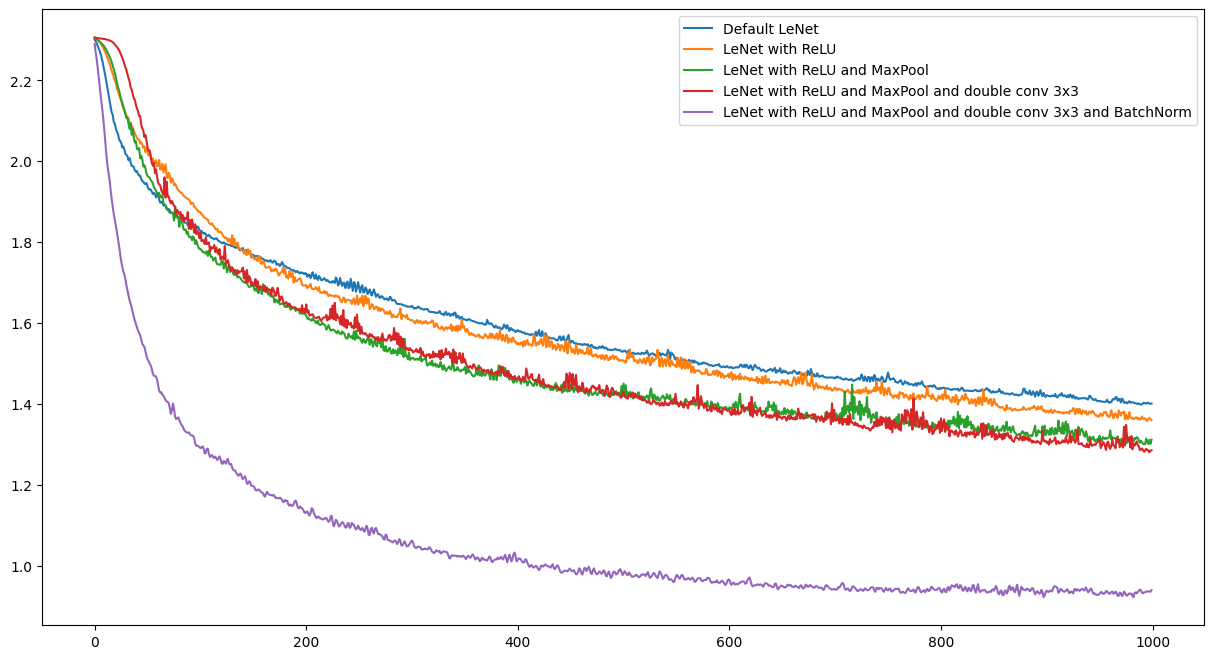

In [63]:
fig, ax = plt.subplots()
ax.plot(test_res_1, label = 'Default LeNet')
ax.plot(test_res_2, label = 'LeNet with ReLU')
ax.plot(test_res_3, label = 'LeNet with ReLU and MaxPool')
ax.plot(test_res_4, label = 'LeNet with ReLU and MaxPool and double conv 3x3')
ax.plot(test_res_5, label = 'LeNet with ReLU and MaxPool and double conv 3x3 and BatchNorm')
ax.legend(loc = 1)
fig.set_figwidth(15) 
fig.set_figheight(8)  

In [64]:
from sklearn.metrics import f1_score

In [65]:
f1_score(basic_lenet.to('cpu').predict(X_test).argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted')

<ipython-input-43-949ff718de1a>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.sm(x)


0.502361366970571

In [37]:
f1_score(relu_lenet.to('cpu').predict(X_test).argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted')

<ipython-input-18-4f7e289dc168>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.sm(x)


0.5972613614926209

In [38]:
f1_score(relu_maxpool_lenet.to('cpu').predict(X_test).argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted')


<ipython-input-22-3c926cdfff33>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.sm(x)


0.615327505790937

In [39]:
f1_score(lenet_rmd.to('cpu').predict(X_test).argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted')

<ipython-input-26-4cb2af4846ef>:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.sm(x)


0.637254997957655

In [66]:
f1_score(lenet_rmdb.to('cpu').predict(X_test).argmax(dim = 1).tolist(), y_test.tolist(), average = 'weighted')

<ipython-input-59-c8978c06524a>:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.sm(x)


0.6757435602503631

# Часть 2

In [18]:
from torchvision.models import alexnet, googlenet, vgg11, resnet18

In [39]:
import torchvision.transforms as transforms

In [40]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
transform=transform

In [31]:
alexnet_model = alexnet()
alexnet_model.classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=9216, out_features=4096, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(p=0.5, inplace=False),
                                         nn.Linear(in_features=4096, out_features=4096, bias=True),
                                         nn.ReLU(inplace=True),
                                         nn.Linear(in_features=4096, out_features=10, bias=True))

In [32]:
alexnet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
alexnet_model.forward(X_test)

RuntimeError: ignored

In [36]:
X_test.shape

torch.Size([10000, 3, 32, 32])

In [ ]:
def predict_transefered_model(model, X):
    return 